In [2]:
import requests # using this just because i don't want to download the entire csv
import pandas as pd

url = 'https://data.wprdc.org/api/3/action/datastore_search'
params = {
    'resource_id': '29462525-62a6-45bf-9b5e-ad2e1c06348d', # check this in wprdc
    'limit': 815417 
}
response = requests.get(url, params=params)
records = response.json()['result']['records']


df = pd.DataFrame(records)

# only save the valid and meaningful entries
df_filtered = df[(df['latitude'].notnull()) & (df['longitude'].notnull()) & (df['longitude'] != 0.000000)& (df['latitude'] != 0.000000)]

df_filtered.to_csv('filtered_311.csv', index=False)

print(f"Saved {len(df_filtered)} records with coordinates.") # check whether the work has been successful


Saved 29820 records with coordinates.


In [2]:
# importing libraries for data cleaning and plotting
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
# importing 
df_311 = pd.read_csv('filtered_311.csv')

In [3]:
# double checking everything is ready for the next step
print("Number of valid 311 records:", len(df_311))
print(df_311[['latitude', 'longitude']].head(10))

Number of valid 311 records: 29820
    latitude  longitude
0  40.443452 -80.004199
1  40.405903 -79.911995
2  40.479870 -79.916472
3  40.448091 -79.996128
4  40.479870 -79.916472
5  40.439236 -80.010609
6  40.482654 -79.916638
7  40.446735 -79.999769
8  40.446432 -79.999620
9  40.448080 -80.040519


In [4]:
# checking shapefile crs to make sure everything is on the same scale
print("Original shapefile CRS:", gpd.read_file('Neighborhood boundaries/neighborhoods (1)/Neighborhoods_.shp').crs)


Original shapefile CRS: EPSG:2272


In [5]:
geometry = [Point(xy) for xy in zip(df_311['longitude'], df_311['latitude'])]
gdf_311 = gpd.GeoDataFrame(df_311, geometry=geometry, crs="EPSG:4326")
gdf_311 = gdf_311.to_crs("EPSG:2272")


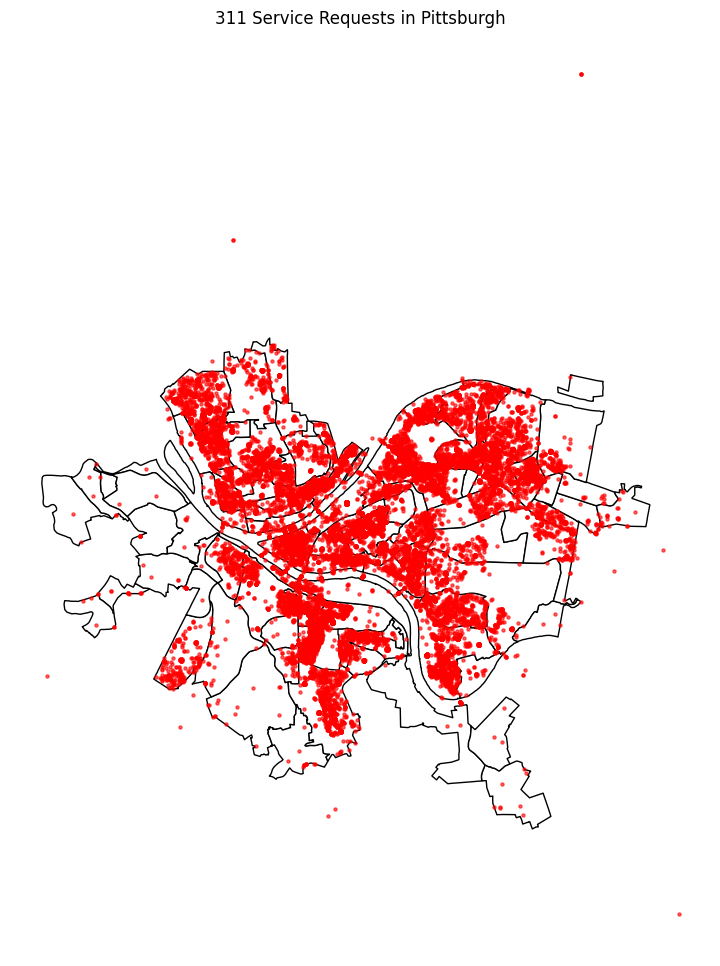

In [6]:
pgh_shp = gpd.read_file('Neighborhood boundaries/neighborhoods (1)/Neighborhoods_.shp')
fig, ax = plt.subplots(figsize=(12, 12))
pgh_shp.plot(ax=ax, color='white', edgecolor='black')
gdf_311.plot(ax=ax, markersize=5, color='red', alpha=0.6)
plt.title("311 Service Requests in Pittsburgh")
plt.axis('off')
plt.show()

In [8]:
gdf_joined = gpd.sjoin(gdf_311, pgh_shp, how='left', predicate='within')
counts = gdf_joined.groupby('hood').size().reset_index(name='request_count')
df = pd.DataFrame(counts)
df["score"] = ((2982 - df["request_count"]) / 2982) * 100
df["score"] = df["score"].round(2)
counts_sorted = df.sort_values(by='score', ascending=False)
counts_sorted.to_csv('311_counts_by_neighborhood.csv', index=False)
print(counts_sorted)


                         hood  request_count  score
66                   Sheraden              2  99.93
29                     Esplen              2  99.93
30                  Fairywood              2  99.93
52              New Homestead              3  99.90
35                       Hays              3  99.90
..                        ...            ...    ...
16  Central Business District           1068  64.19
9                  Bloomfield           1073  64.02
12           Brighton Heights           1079  63.82
36                  Hazelwood           1104  62.98
47         Marshall-Shadeland           1278  57.14

[88 rows x 3 columns]
